## Load Packages

In [1]:
using Dates 

include("printmat.jl")
include("printTable.jl")

printmatDate (generic function with 8 methods)

In [3]:
using Plots
backend = "gr"                        #"gr" (default), "pyplot" 

if backend == "pyplot"
    pyplot(size=(600,400))
else    
    gr(size=(480,320))
    default(fmt = :svg)
end

# Predictions from an AR(1)

Consider an AR(1) with mean $\mu$

$r_{t+1}-\mu=\rho\left(  r_{t}-\mu\right)  +\varepsilon_{t+1}$

The forecast (based on information in $t$) for $t+s$ is

$\text{E}_{t}r_{t+s}=\left(  1-\rho^{s}\right)  \mu+\rho ^{s}r_{t}.$

The examples below assume that periods are months ($t$ to $t+1$ is a month).

In [4]:
"""
    AR1Prediction(x0,ρ,μ,s)

Calculate forecast from AR(1)

x0,ρ,μ,s: scalars
"""
function AR1Prediction(x0,ρ,μ,s)      
    E0xs = (1-ρ^s)*μ + ρ^s*x0
    return E0xs
end

AR1Prediction (generic function with 1 method)

In [5]:
ρ = 0.975
μ = 0.05

printlnPs("Prediction for t+50, assuming current r=0.07: ",AR1Prediction(0.07,ρ,μ,50))

sMax = 120
sM = 1:sMax
x0 = [0.03;0.05;0.07]

xPred = fill(NaN,(sMax,length(x0)))          #predictions[horizon,today's value]
for s in sM, j = 1:length(x0)
    xPred[s,j] = AR1Prediction(x0[j],ρ,μ,s)
end

Prediction for t+50, assuming current r=0.07:      0.056


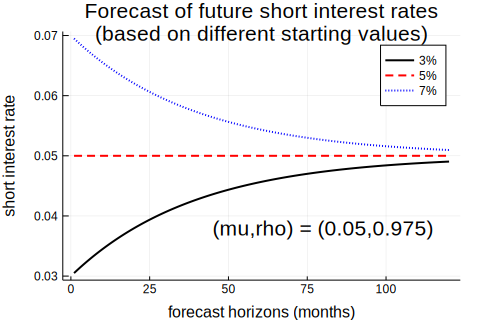

In [6]:
p1 = plot(sM,xPred[:,1],color=:black,linewidth=2,label="3%")
plot!(sM,xPred[:,2],color=:red,line=(:dash,2),linewidth=2,label="5%")
plot!(sM,xPred[:,3],color=:blue,line=(:dot),linewidth=2,label="7%")
title!("Forecast of future short interest rates\n (based on different starting values)")
xlabel!("forecast horizons (months)")
ylabel!("short interest rate")
annotate!(80,0.038,"(mu,rho) = ($μ,$ρ)")

# The Vasicek Model

The Vasicek model (without risk premia) implies that 

$
y_{t}(n) =a(n)+b(n)r_{t} \: \text{, where }
$

$
a(n)     = \mu\left[  1-b(n)\right],\\
b(n)     =(1-\rho^{n})/[(1-\rho)n].
$

If the periods are one month, then $y_{t}(36)$ is the (annualized) continuously compounded interest rate for a bond maturing in 36 months (...3 years).

In [7]:
"""
    Vasicek(r,ρ,μ,n)

Vasicek model: calculate interest rate and (a,b) coeffs
r,ρ,μ,n: scalars
"""
function Vasicek(r,ρ,μ,n)                   
    if ρ == 1.0
        b = 1.0
    else    
        b = (1-ρ^n)/((1-ρ)*n)
    end    
    a = μ*(1-b)
    y = a + b*r
    return y,a,b
end

Vasicek (generic function with 1 method)

In [8]:
yM = fill(NaN,(sMax,length(x0)))        #interest rates, different starting values in columns
ab = fill(NaN,(sMax,2))                 #a and b coefs 
for n in sM, j = 1:length(x0)
    local a, y, b
    (y,a,b) = Vasicek(x0[j],ρ,μ,n)
    yM[n,j] = y
    ab[n,:] = [a b]                     #overwriting, but the same across x0 values
end

println("a and b for the first few maturities")
printmat([sM[1:4]  ab[1:4,1]*100 ab[1:4,2]] )

a and b for the first few maturities
     1.000     0.000     1.000
     2.000     0.062     0.988
     3.000     0.124     0.975
     4.000     0.184     0.963



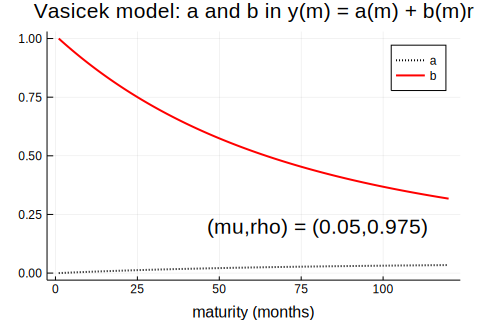

In [9]:
p1 = plot(sM,ab[:,1],color=:black,line=(:dot),linewidth=2,label="a")
plot!(sM,ab[:,2],color=:red,linewidth=2,label="b")
title!("Vasicek model: a and b in y(m) = a(m) + b(m)r")
xlabel!("maturity (months)")
annotate!(80,0.2,"(mu,rho) = ($μ,$ρ)")

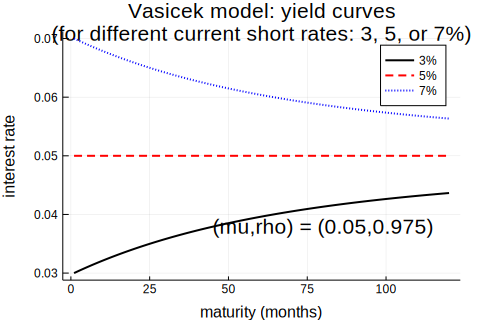

In [10]:
p1 = plot(sM,yM[:,1],color=:black,linewidth=2,label="3%")
plot!(sM,yM[:,2],color=:red,line=(:dash,2),linewidth=2,label="5%")
plot!(sM,yM[:,3],color=:blue,line=(:dot),linewidth=2,label="7%")
title!("Vasicek model: yield curves\n (for different current short rates: 3, 5, or 7%)")
xlabel!("maturity (months)")
ylabel!("interest rate")
annotate!(80,0.038,"(mu,rho) = ($μ,$ρ)")

# Hedging Using the Vasicek Model

Recall that the change of the (value of the) hedge portfolio is 

$\begin{equation}
\Delta V=h\Delta P_{H}-\Delta P_{L}
\end{equation}$


1. For an initial value of the short log interest rate $r$, use the Vasicek model to calculate all spot rates needed to value the bond portfolios.

2. Use the spot interest rates ($y(m)$) to calculate the prices of both the liability and the hedge bond.

3. Redo points 1 and 2, but starting from a somewhat different short rate.
    
4. Calculate the $h$ value that makes $\Delta V = 0$, that is, $h=\Delta P_{L}/\Delta P_{H}$.

In the example below, the liability pays 0.2 every 12 months for 10 years. The hedge bond is a 3-year zero coupon bond. 
Most likely, a good hedge needs to invest more than proportional in the hedge bond - to make the interest rate sensitivity similar to that of the liability.

The Vasicek model is implemented such that periods are months, that is, $y(36)$ is the (annualized, continuously compounded) interest rate for a 36 month bond.

In [11]:
cfL = repeat([zeros(11);0.2],outer=10)   #cash flow of liability
nL  = 1:120                              #times of the cash flows, months
cfH = [zeros(35);1]                      #cash flow of hedge bond, 3-year zero-coupon bond
nH  = 1:36                               #months

1:36

### From Chapter on Bonds 1

Recall, the bond price $P$ is the present value of the future cash flows $cf_k$

$P = \sum_{k=1}^{K} \frac{cf_{k}}{\exp\left[m_{k} y(m_{k})\right]  }$,

where $y(m_k)$ is the continuously compounded (annualized) interest rate on a bond maturing in $m_k$ years.

(You can replace the denominator with $[  1+Y(m_{k})]^{m_{k}}$ if you prefer to work with effective rates.)

In [12]:
"""
Y:  scalar or K vector of interest rates
cf: scalar or K vector of cash flows
m: K vector of times of cash flows
"""
function BondPrice3(Y,cf,m)                #cf is a vector of all cash flows
    cdisc = cf./((Y.+1).^m)                #c/(1+y1)^t1 + c/(1+y2)^t2 + ...+ c/(1+y2)^m
    P     = sum(cdisc)                     #price
    return P
end

BondPrice3 (generic function with 1 method)

For given parameters of the Vasicek model ($\rho,\mu$), calculate all interests needed to value the bonds portfolios.

In [13]:
ρ = 0.975                       #experiment with this
μ = 0.05

r₀ = 0.05                         #initial (day 0) short log interest rate
r₁ = 0.049                        #after change (day 1)
#r₁ = 0.03                         #experiment with this  

y₀ = fill(NaN,length(nL))        #yield curve, before
y₁ = copy(y₀)                     #yield curve, after
for n in nL
    y₀[n] = Vasicek(r₀,ρ,μ,n)[1]
    y₁[n] = Vasicek(r₁,ρ,μ,n)[1]
end

With the two yield curves (different short rate values) from the Vasicek model, calculate bond prices. 

Notice that 
1. In the bond valuation formula, periods ($m$) are years. 
2. In the Vasicek model as implemented above, periods ($n$) are months.

In [14]:
PL₀ = BondPrice3(y₀,cfL,nL/12)       #liability, before, /12 to get years
PL₁ = BondPrice3(y₁,cfL,nL/12)       #after 
ΔPL = PL₁ - PL₀

PH₀ = BondPrice3(y₀[nH],cfH,nH/12)                   #hedge bond
PH₁ = BondPrice3(y₁[nH],cfH,nH/12)                   
ΔPH = PH₁ - PH₀

h = ΔPL/ΔPH
hdollars = h*PH₀/PL₀

xy = [ΔPL;ΔPH;h;hdollars]
printTable(xy,[" "],["ΔPL";"ΔPH";"h";"h*PH₀/PL₀"])

println("...investigate how these results change when ρ does")

                   
ΔPL           0.003
ΔPH           0.002
h             2.101
h*PH₀/PL₀     1.175

...investigate how these results change when ρ does
